In [1]:
#import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 18,8
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import seaborn as sns

In [2]:
dateparser = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
dataset = pd.read_csv('C:/Faculta anul 3 sem 2/Licenta/DJIA/CAT.csv', sep=',', index_col = 'Date', parse_dates = ['Date'], date_parser = dateparser).fillna(0)
dataset.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,158.300003,159.389999,156.029999,157.039993,143.586136,5108400
2018-01-03,157.039993,157.490005,155.399994,157.279999,143.805557,4146100
2018-01-04,157.889999,159.580002,157.020004,159.440002,145.780487,4865800
2018-01-05,160.259995,162.050003,159.639999,161.960007,148.084625,3945400
2018-01-08,164.110001,166.429993,162.550003,166.029999,151.805954,5929200


In [3]:
dataset.count()

Open         838
High         838
Low          838
Close        838
Adj Close    838
Volume       838
dtype: int64

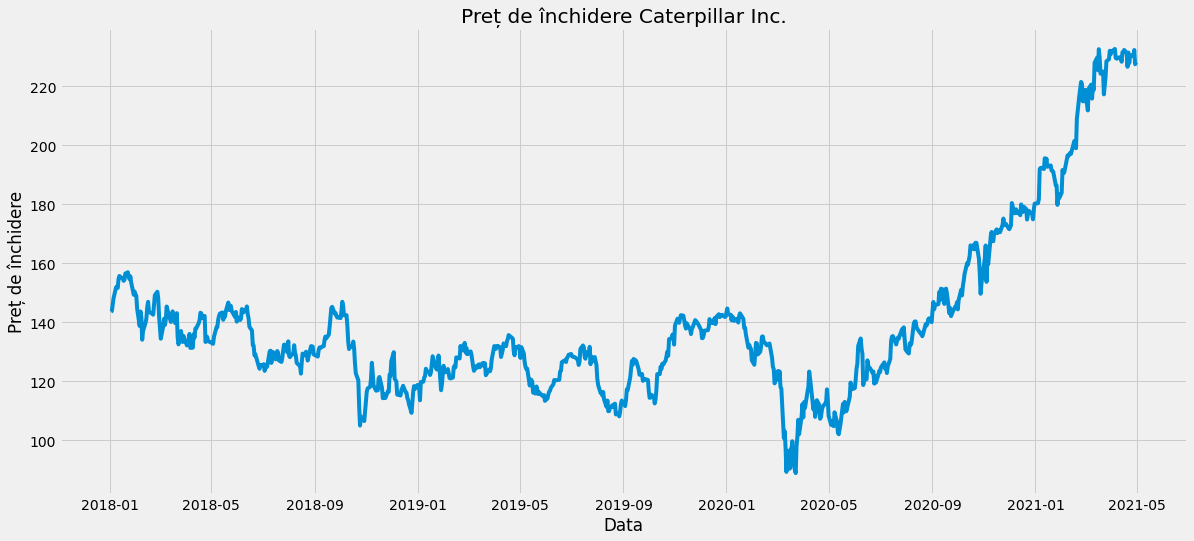

In [4]:
plt.xlabel('Data')
plt.ylabel('Preț de închidere')
plt.plot(dataset['Adj Close'])
plt.title('Preț de închidere Caterpillar Inc.')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

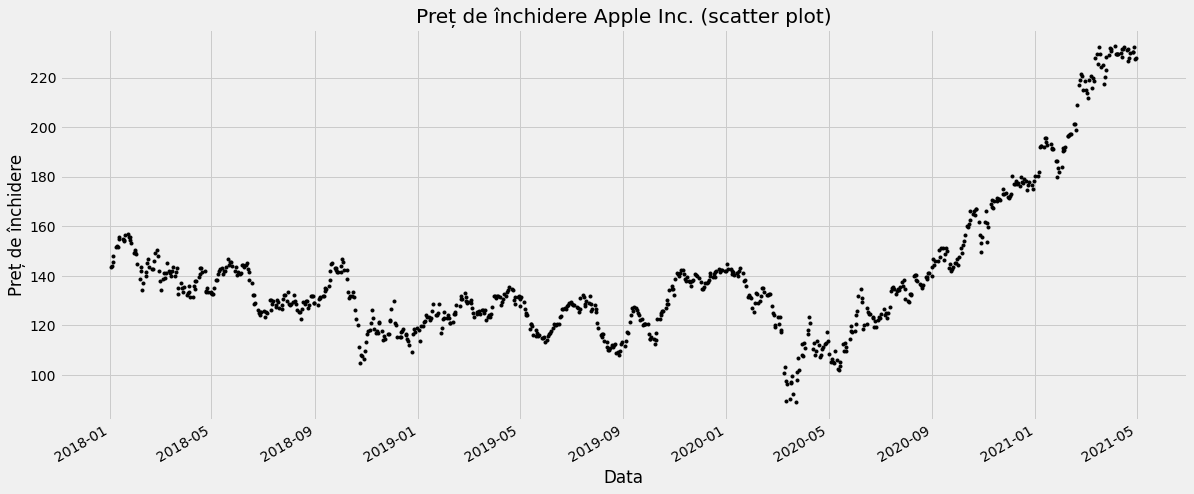

In [5]:
df_close = dataset['Adj Close']
df_close.plot(style='k.')
plt.xlabel('Data')
plt.ylabel('Preț de închidere')
plt.title('Preț de închidere Apple Inc. (scatter plot)')
plt.show

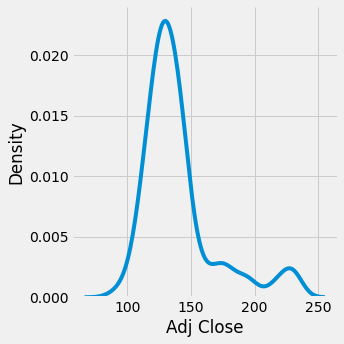

In [6]:
density = sns.displot(dataset, x="Adj Close", kind="kde")

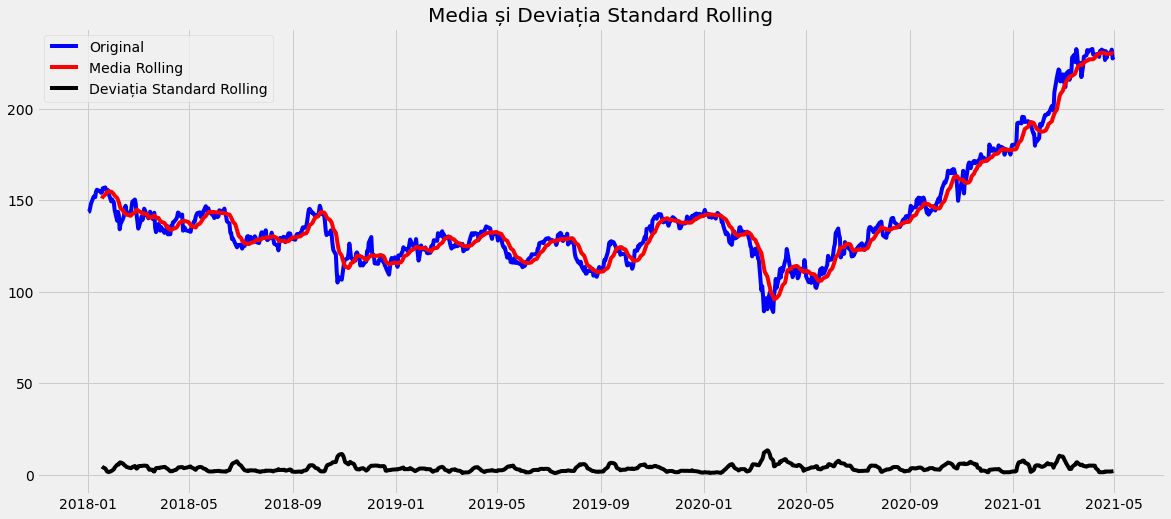

Rezultatele testului Dickey-Fuller Augmentat: 
Test statistic             0.266302
p-value                    0.975745
Nr. decalaje folosite     11.000000
Nr. observatii           826.000000
valoare critica (1%)      -3.438292
valoare critica (5%)      -2.865045
valoare critica (10%)     -2.568637
dtype: float64


In [7]:
def test_stationarity(timeseries):
    rolling_mean = timeseries.rolling(12).mean()
    rolling_std = timeseries.rolling(12).std()
    plt.plot(timeseries, color = 'blue', label = 'Original')
    plt.plot(rolling_mean, color = 'red', label='Media Rolling')
    plt.plot(rolling_std, color = 'black', label = 'Deviația Standard Rolling')
    plt.legend(loc='best')
    plt.title('Media și Deviația Standard Rolling')
    plt.show(block=False)
    
    print('Rezultatele testului Dickey-Fuller Augmentat: ')
    adft = adfuller(timeseries, autolag = 'AIC')
    results = pd.Series(adft[0:4],index=['Test statistic','p-value','Nr. decalaje folosite','Nr. observatii'])
    for key, value in adft[4].items():
        results['valoare critica (%s)' %key] = value
    print(results)
test_stationarity(df_close)

<Figure size 1296x576 with 0 Axes>

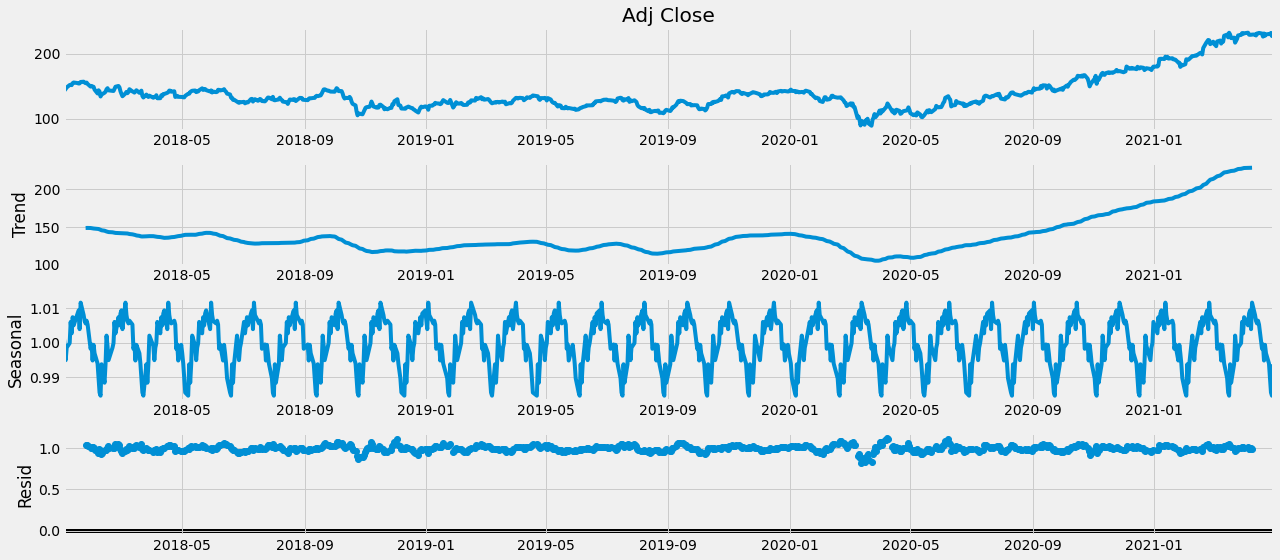

In [8]:
result = seasonal_decompose(df_close, model='multiplicative',freq = 30)
fig = plt.figure()
fig = result.plot()

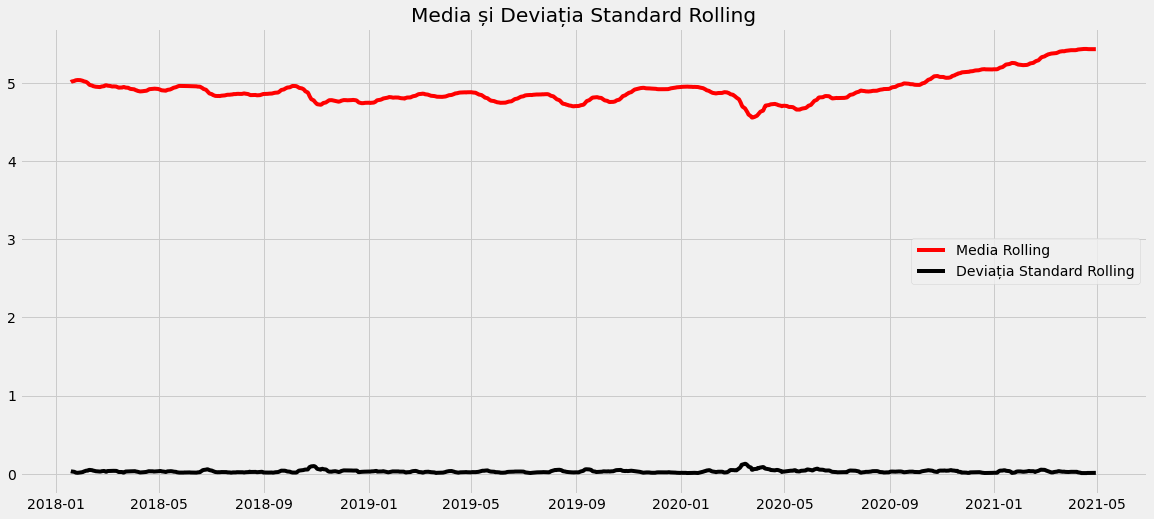

In [9]:
df_log = np.log(df_close)
rolling_mean = df_log.rolling(12).mean()
rolling_std = df_log.rolling(12).std()
plt.title('Media și Deviația Standard Rolling')
plt.plot(rolling_mean, color = 'red', label='Media Rolling')
plt.plot(rolling_std, color = 'black', label = 'Deviația Standard Rolling')
plt.legend(loc='best')
plt.show()

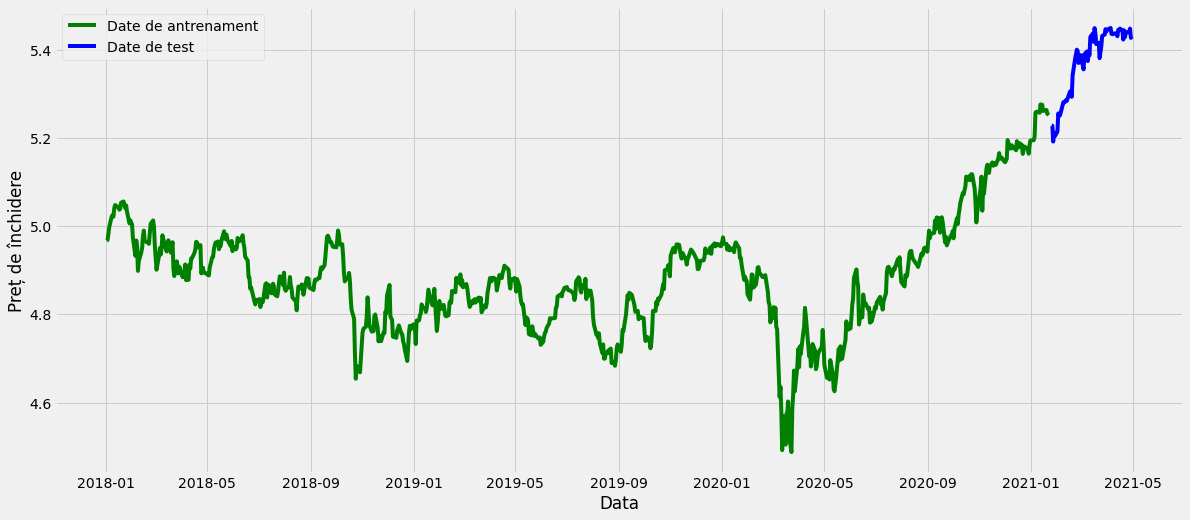

In [10]:
train_data, test_data = df_log[:int(len(df_log)*0.92)], df_log[int(len(df_log)*0.92):]
plt.xlabel('Data')
plt.ylabel('Preț de închidere')
plt.plot(train_data, 'green', label = "Date de antrenament")
plt.plot(test_data, 'blue', label = "Date de test")
plt.legend()

In [11]:
auto_ARIMA = auto_arima(train_data,
                        start_p=0, start_q=0,
                        test = 'adf',
                        max_p=3, max_q=3,
                        m=1,
                        d=None,
                        seasonal=True,
                        start_P=0, 
                        D=0,
                        trace=True,
                        error_action = 'ignore',
                        suppress_warnings=True,
                        stepwise=True,)
print(auto_ARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3651.145, Time=0.23 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3651.512, Time=0.59 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3651.328, Time=0.54 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3652.935, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3649.367, Time=1.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 2.566 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  770
Model:               SARIMAX(0, 1, 0)   Log Likelihood                1827.467
Date:                Tue, 15 Jun 2021   AIC                          -3652.935
Time:                        10:43:07   BIC                          -3648.290
Sample:                             0   HQIC                         -3651.147
                                - 770                                  

In [13]:
first_diff = train_data - train_data.shift(2)
first_diff = first_diff.dropna(inplace = False)

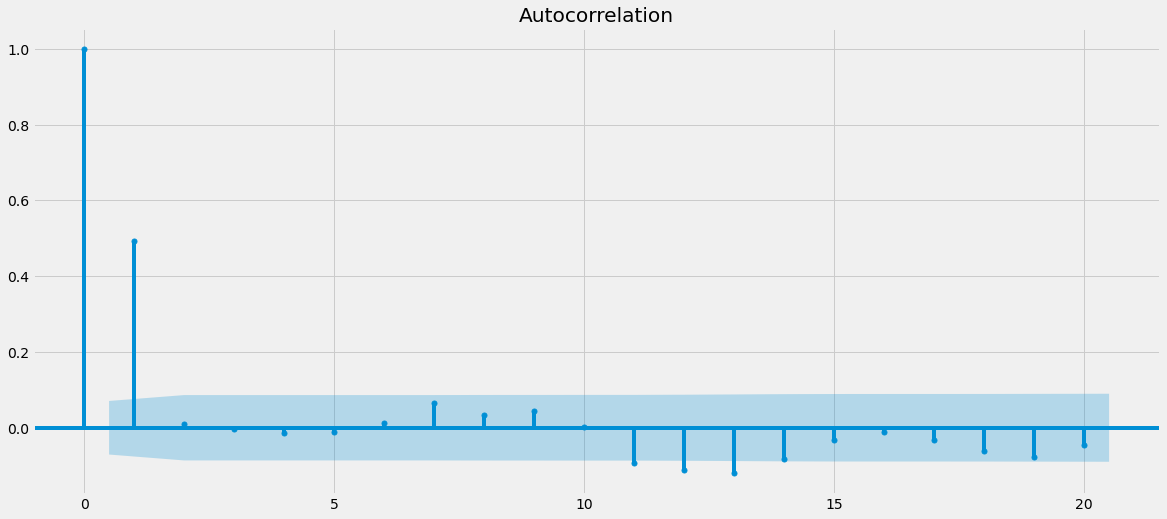

In [15]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
acf_plot = plot_acf(first_diff,lags = 20)

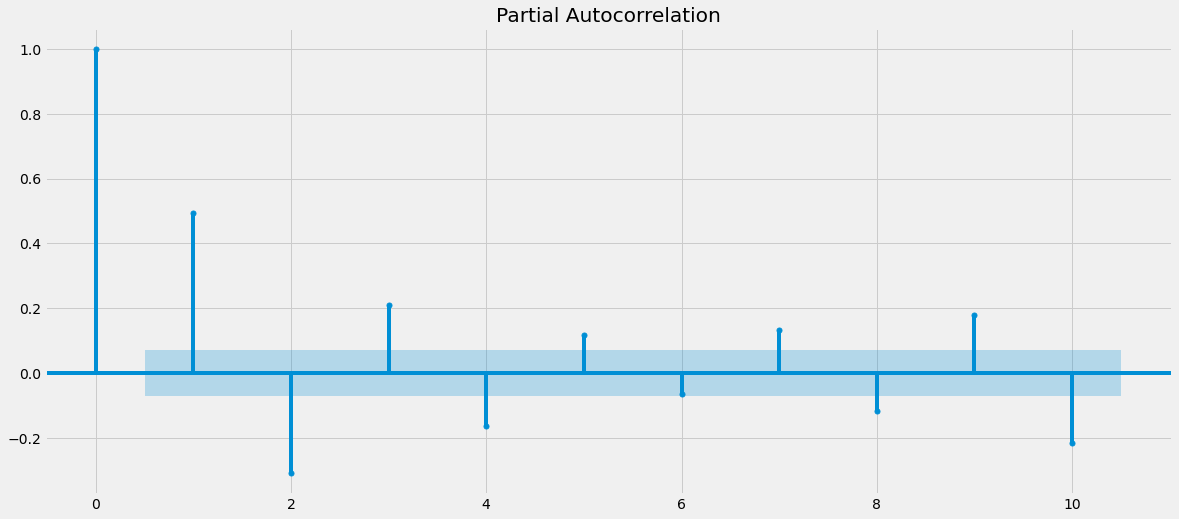

In [16]:
pacf_plot = plot_pacf(first_diff, lags=10)

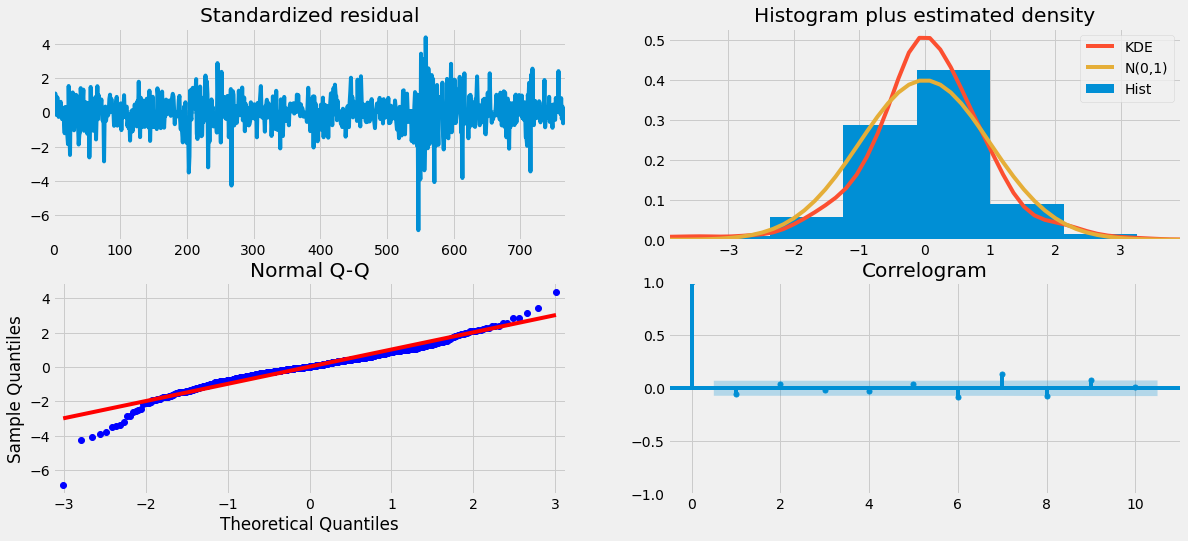

In [12]:
auto_ARIMA.plot_diagnostics()
plt.show()

In [24]:
warnings.filterwarnings('ignore')
model = ARIMA(train_data, order=(0, 2, 1))  
fitted = model.fit(disp=-1, trend = 'nc')  
print(fitted.summary())

                             ARIMA Model Results                              
Dep. Variable:           D2.Adj Close   No. Observations:                  768
Model:                 ARIMA(0, 2, 1)   Log Likelihood                1821.377
Method:                       css-mle   S.D. of innovations              0.022
Date:                Tue, 15 Jun 2021   AIC                          -3638.754
Time:                        10:48:34   BIC                          -3629.466
Sample:                             2   HQIC                         -3635.179
                                                                              
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
ma.L1.D2.Adj Close    -0.9988      0.008   -124.483      0.000      -1.014      -0.983
                                    Roots                                    
                  Real       

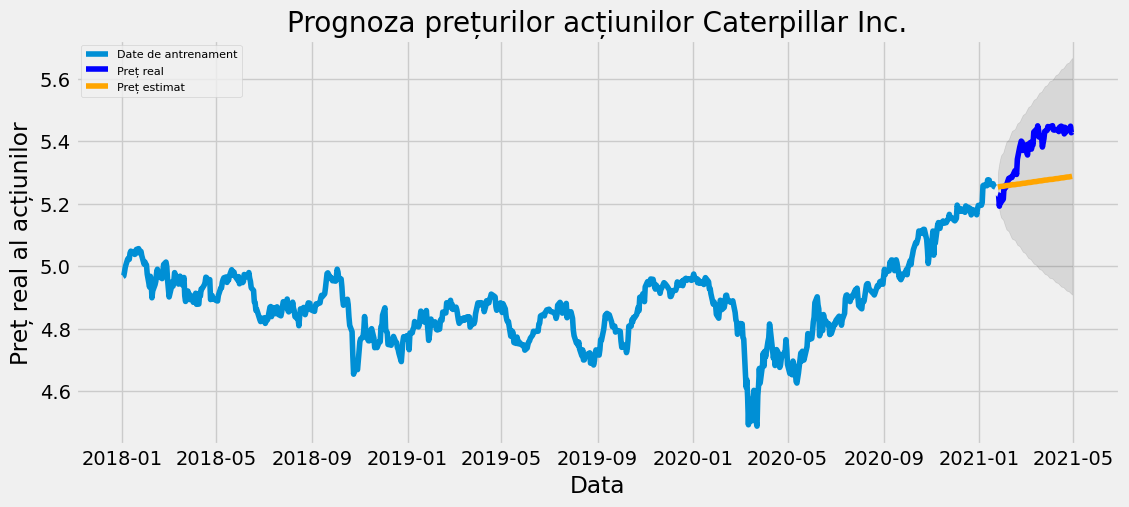

In [18]:
fc, se, conf = fitted.forecast(68, alpha=0.05)
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='Date de antrenament')
plt.plot(test_data, color = 'blue', label='Preț real')
plt.plot(fc_series, color = 'orange',label='Preț estimat')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.title('Prognoza prețurilor acțiunilor Caterpillar Inc.')
plt.xlabel('Data')
plt.ylabel('Preț real al acțiunilor')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [20]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: '+str(mse))
mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))*100
print('MAPE: '+str(mape))

MSE: 687.9442297035665
MAE: 23.377064586030293
RMSE: 26.228690964353646
MAPE: 10.448289773970739
